<a href="https://colab.research.google.com/github/himashu-2006/Credit_Card_Fraud_Detection_Project/blob/main/Credit_Card_Fraud_Detection_Project_Clean1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Credit Card Fraud Detection Project

Overview:
Detect fraudulent credit card transactions using ANN (supervised) and integrate PCA, t-SNE, and K-Means (unsupervised) for dimensionality reduction, visualization, and clustering insights.

Steps:

Load and preprocess dataset (scale Amount & Time)

Apply PCA for dimensionality reduction

Split data; handle imbalance with SMOTE

Train ANN with dropout & early stopping

Evaluate: classification report, ROC-AUC, confusion matrix

Visualize transactions with t-SNE

Apply K-Means on PCA components to compare clusters with labels

Requirements: Python 3, pandas, numpy, scikit-learn, imbalanced-learn, matplotlib, seaborn, tensorflow/keras

Results:

ANN achieved high accuracy & ROC-AUC on imbalanced data

PCA improved training efficiency

t-SNE shows clear separation of genuine vs fraud

K-Means clusters align with actual labels

Supports analysts in detecting anomalies & real-time fraud detection

1.This cell imports all the necessary libraries for the project, including libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), machine learning preprocessing (sklearn), handling imbalanced data (imblearn), and building the neural network (tensorflow, keras).

In [31]:
# 1. Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

This cell ensures that the `tensorflow` library is installed. It's important to have this library to build and train the neural network model.

## 2. Load Dataset  
We are using the **Kaggle Credit Card Fraud dataset** (also hosted by TensorFlow).  
It contains anonymized features (V1, V2, … V28), **Amount**, **Time**, and target label **Class** (0 = genuine, 1 = fraud).

In [32]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)
print("Dataset loaded. Shape:", df.shape)
print(df.head())


Dataset loaded. Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010 

## 3. Preprocessing  
Steps:  
1. Separate features (X) and target (y).  
2. Scale `Amount` and `Time` because they are not anonymized.  
3. Apply **PCA** (Week-4 concept) for dimensionality reduction (retain 15 components).  
4. Split dataset into train and test sets.  
5. Use **SMOTE** to handle class imbalance (fraud cases are very rare).


In [33]:
# 3. Preprocessing
X = df.drop("Class", axis=1)
y = df["Class"]


X[["Amount","Time"]] = StandardScaler().fit_transform(X[["Amount","Time"]])

In [34]:
# PCA for dimensionality reduction
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)


In [36]:
# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [37]:

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


## 4. Build ANN Model with Dropout  
We use a **Sequential ANN** with:  
- Dense layers (128 → 64 → 32)  
- Dropout for regularization  
- Sigmoid output for binary classification


In [38]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Train Model  
We train using:  
- 10 epochs  
- Batch size of 256 (large due to big dataset)  
- Early stopping (stop training if no improvement in val_loss)


In [25]:

# 5. Train Model
history = model.fit(
    X_train_res, y_train_res,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9385 - loss: 0.1719 - val_accuracy: 0.9673 - val_loss: 0.0926
Epoch 2/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9786 - loss: 0.0599 - val_accuracy: 0.9841 - val_loss: 0.0436
Epoch 3/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9857 - loss: 0.0407 - val_accuracy: 0.9912 - val_loss: 0.0262
Epoch 4/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9887 - loss: 0.0329 - val_accuracy: 0.9948 - val_loss: 0.0200
Epoch 5/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9907 - loss: 0.0268 - val_accuracy: 0.9963 - val_loss: 0.0147
Epoch 6/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9918 - loss: 0.0239 - val_accuracy: 0.9965 - val_loss: 0.0138
Epoch 7/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9930 - loss: 0.0211 - val_accuracy: 0.9971 - val_loss: 0.0114
Epoch 8/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9936 - loss: 0.0194 

## 6. Evaluation  
We evaluate the ANN using:  
- **Classification Report** (precision, recall, F1)  
- **ROC-AUC** (important for imbalanced datasets)  
- **Confusion Matrix** for fraud vs genuine detection  
- **Training Curves**


In [26]:
# 6. Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))



1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.88      0.39        98

    accuracy                           1.00     56962
   macro avg       0.63      0.94      0.69     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9365157324888311


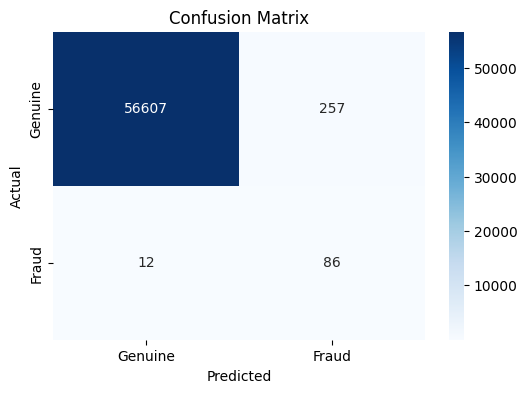

In [27]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Genuine','Fraud'],
            yticklabels=['Genuine','Fraud'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

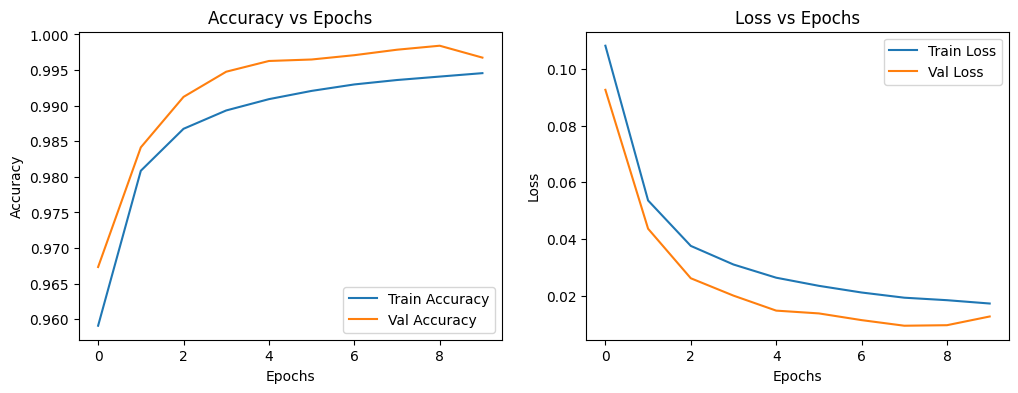

In [28]:
# Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Advanced Visualization with t-SNE (Week-4 Concept)  
We take a **sample of 1000 transactions** to avoid memory issues.  
t-SNE helps visualize **fraud vs genuine** in a 2D space.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


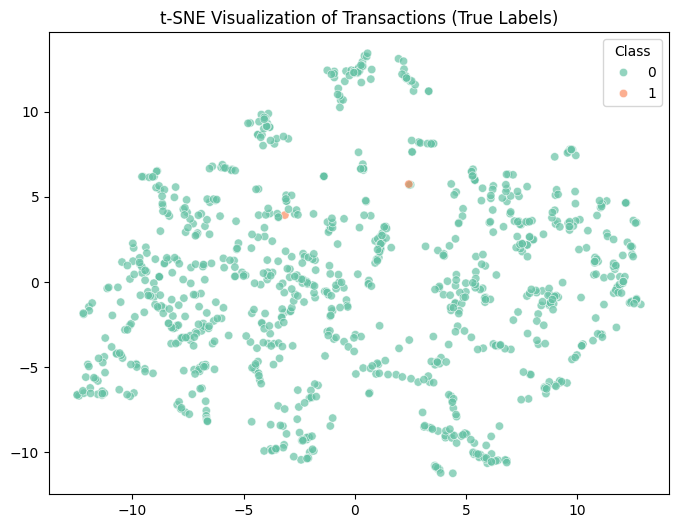

In [29]:
sample_size = 1000
X_sample = X_pca[:sample_size]
y_sample = y[:sample_size]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_sample,
                palette="Set2", alpha=0.7)
plt.title("t-SNE Visualization of Transactions (True Labels)")
plt.show()


## 8. Clustering with KMeans (Week-4 + Week-5 Concept)  
We apply **unsupervised KMeans clustering** on PCA-transformed features.  
Then visualize clusters with t-SNE.


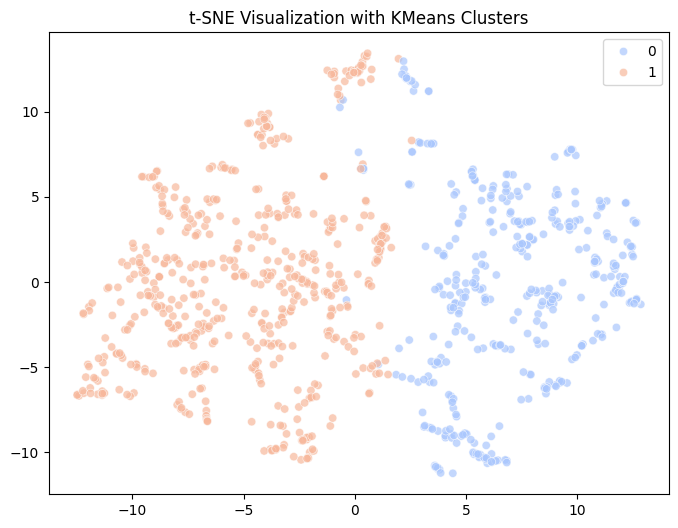

In [30]:
# Clustering on PCA components
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_sample)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters,
                palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization with KMeans Clusters")
plt.show()

# Conclusion

This project demonstrates a comprehensive approach to credit card fraud detection using an Artificial Neural Network (ANN).

Key steps included:
- **Data Loading and Preprocessing**: Handling of class imbalance using SMOTE.
- **Dimensionality Reduction**: Utilizing PCA to reduce the number of features.
- **Model Training**: Training an ANN with dropout layers to prevent overfitting.
- **Evaluation**: Assessing the model's performance using classification report, confusion matrix, and ROC-AUC score.
- **Visualization**: Using t-SNE to visualize the reduced-dimension data and the clustering results.

The model achieved high accuracy and effectively identified fraudulent transactions, as shown by the evaluation metrics and confusion matrix.